In [1]:
from torchvision.models.feature_extraction import create_feature_extractor

from torchvision.utils import save_image

import torch

from tqdm import tqdm

from utils.dataset_pretrained import Dataset

import numpy as np

import matplotlib.pyplot as plt

import numpy as np

In [2]:
batch_size = 64

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
alexnet.to(device) # send the alexnet to the chosen device ('cpu' or 'cuda')
alexnet.eval() # set the alexnet to evaluation mode, since you are not training it

model_layer = "features.2" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(alexnet, return_nodes=[model_layer])
feature_extractor.to(device)
feature_extractor.eval()

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [4]:
# loading dataset + creating train test split for verifying performance
dataset = Dataset("gaze-dataset")

train_set, val_set = torch.utils.data.random_split(dataset, [10000, 1382])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

Loading dataset sample names...
Training images: 11382


In [5]:
class RegressionHead(torch.nn.Module):
    def __init__(self):
        super(RegressionHead, self).__init__()
        
        self.flatten = torch.nn.Flatten()

        self.linear1 = torch.nn.Linear(46656, 2)

    def forward(self, x):
        x = self.flatten(x)

        return self.linear1(x)

In [6]:
regression_head = RegressionHead().to(device)
regression_head.to(device)

RegressionHead(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=46656, out_features=2, bias=True)
)

In [7]:
EPOCHS = 50

mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)

In [8]:
losses = []
val_losses = []

for epoch in range(EPOCHS):
    print("Epoch: " + str(epoch))
    for i, (inputs, targets, head_pose) in tqdm(enumerate(train_loader), total=int(10000/batch_size)+1):
        optimizer.zero_grad()
        
        inputs = inputs.to(device)

        output = feature_extractor(inputs)["features.2"]
        output = regression_head(output)

        loss = mse_loss(output, targets.to(device))
        
        if i == len(train_loader)-1:
            print("Train loss: " + str(loss.item()))
            losses.append(loss.item())
            
        loss.backward()
    
        optimizer.step()
    
    for i, (inputs, targets, head_pose) in tqdm(enumerate(val_loader), total=int(1382/batch_size)+1):
        inputs = inputs.to(device)

        output = feature_extractor(inputs)["features.2"]
        output = regression_head(output)

        loss = mse_loss(output, targets.to(device))
        
        if i == len(val_loader)-1:
            print("Val loss: " + str(loss.item()))
            val_losses.append(loss.item())

Epoch: 0


100%|██████████| 157/157 [00:32<00:00,  4.79it/s]


Train loss: 0.05025358870625496


100%|██████████| 22/22 [00:04<00:00,  5.10it/s]


Val loss: 0.03416677564382553
Epoch: 1


100%|██████████| 157/157 [00:15<00:00,  9.91it/s]


Train loss: 0.0416596457362175


100%|██████████| 22/22 [00:02<00:00, 10.16it/s]


Val loss: 0.02439006231725216
Epoch: 2


100%|██████████| 157/157 [00:15<00:00,  9.88it/s]


Train loss: 0.02915780618786812


100%|██████████| 22/22 [00:02<00:00, 10.26it/s]


Val loss: 0.02852405048906803
Epoch: 3


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.03964647650718689


100%|██████████| 22/22 [00:02<00:00, 10.27it/s]


Val loss: 0.04549231752753258
Epoch: 4


100%|██████████| 157/157 [00:15<00:00, 10.01it/s]


Train loss: 0.03297467529773712


100%|██████████| 22/22 [00:02<00:00, 10.34it/s]


Val loss: 0.036120980978012085
Epoch: 5


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Train loss: 0.026776479557156563


100%|██████████| 22/22 [00:02<00:00, 10.27it/s]


Val loss: 0.013310971669852734
Epoch: 6


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.019431691616773605


100%|██████████| 22/22 [00:02<00:00, 10.24it/s]


Val loss: 0.01710922084748745
Epoch: 7


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Train loss: 0.03882782906293869


100%|██████████| 22/22 [00:02<00:00, 10.27it/s]


Val loss: 0.03739823028445244
Epoch: 8


100%|██████████| 157/157 [00:15<00:00, 10.00it/s]


Train loss: 0.033422522246837616


100%|██████████| 22/22 [00:02<00:00, 10.24it/s]


Val loss: 0.025459876284003258
Epoch: 9


100%|██████████| 157/157 [00:15<00:00,  9.94it/s]


Train loss: 0.02700662612915039


100%|██████████| 22/22 [00:02<00:00, 10.26it/s]


Val loss: 0.03481798991560936
Epoch: 10


100%|██████████| 157/157 [00:15<00:00, 10.00it/s]


Train loss: 0.03598596528172493


100%|██████████| 22/22 [00:02<00:00, 10.26it/s]


Val loss: 0.014954942278563976
Epoch: 11


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.0138135040178895


100%|██████████| 22/22 [00:02<00:00, 10.38it/s]


Val loss: 0.04197445884346962
Epoch: 12


100%|██████████| 157/157 [00:15<00:00, 10.04it/s]


Train loss: 0.012554744258522987


100%|██████████| 22/22 [00:02<00:00, 10.16it/s]


Val loss: 0.02237655036151409
Epoch: 13


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Train loss: 0.024440838024020195


100%|██████████| 22/22 [00:02<00:00, 10.28it/s]


Val loss: 0.019682452082633972
Epoch: 14


100%|██████████| 157/157 [00:15<00:00,  9.94it/s]


Train loss: 0.030780360102653503


100%|██████████| 22/22 [00:02<00:00, 10.16it/s]


Val loss: 0.017644863575696945
Epoch: 15


100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


Train loss: 0.032531242817640305


100%|██████████| 22/22 [00:02<00:00, 10.26it/s]


Val loss: 0.01944706402719021
Epoch: 16


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.008205840364098549


100%|██████████| 22/22 [00:02<00:00, 10.23it/s]


Val loss: 0.026397591456770897
Epoch: 17


100%|██████████| 157/157 [00:15<00:00,  9.98it/s]


Train loss: 0.018687287345528603


100%|██████████| 22/22 [00:02<00:00, 10.35it/s]


Val loss: 0.02151423692703247
Epoch: 18


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Train loss: 0.016859954223036766


100%|██████████| 22/22 [00:02<00:00, 10.31it/s]


Val loss: 0.022802677005529404
Epoch: 19


100%|██████████| 157/157 [00:15<00:00, 10.01it/s]


Train loss: 0.023491520434617996


100%|██████████| 22/22 [00:02<00:00, 10.29it/s]


Val loss: 0.031248152256011963
Epoch: 20


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Train loss: 0.02081207185983658


100%|██████████| 22/22 [00:02<00:00, 10.30it/s]


Val loss: 0.036586496978998184
Epoch: 21


100%|██████████| 157/157 [00:15<00:00, 10.04it/s]


Train loss: 0.018636979162693024


100%|██████████| 22/22 [00:02<00:00, 10.28it/s]


Val loss: 0.01812487468123436
Epoch: 22


100%|██████████| 157/157 [00:15<00:00, 10.00it/s]


Train loss: 0.025925125926733017


100%|██████████| 22/22 [00:02<00:00, 10.25it/s]


Val loss: 0.021992884576320648
Epoch: 23


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.021788887679576874


100%|██████████| 22/22 [00:02<00:00, 10.30it/s]


Val loss: 0.023503834381699562
Epoch: 24


100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


Train loss: 0.017638299614191055


100%|██████████| 22/22 [00:02<00:00, 10.26it/s]


Val loss: 0.02621205523610115
Epoch: 25


100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


Train loss: 0.017710812389850616


100%|██████████| 22/22 [00:02<00:00, 10.23it/s]


Val loss: 0.0133833521977067
Epoch: 26


100%|██████████| 157/157 [00:15<00:00,  9.96it/s]


Train loss: 0.007074713706970215


100%|██████████| 22/22 [00:02<00:00, 10.20it/s]


Val loss: 0.02599223703145981
Epoch: 27


100%|██████████| 157/157 [00:15<00:00,  9.95it/s]


Train loss: 0.012661444954574108


100%|██████████| 22/22 [00:02<00:00, 10.20it/s]


Val loss: 0.03143521025776863
Epoch: 28


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Train loss: 0.010339492931962013


100%|██████████| 22/22 [00:02<00:00, 10.28it/s]


Val loss: 0.0194181390106678
Epoch: 29


100%|██████████| 157/157 [00:15<00:00,  9.95it/s]


Train loss: 0.01808595284819603


100%|██████████| 22/22 [00:02<00:00, 10.22it/s]


Val loss: 0.017737550660967827
Epoch: 30


100%|██████████| 157/157 [00:15<00:00,  9.94it/s]


Train loss: 0.011983762495219707


100%|██████████| 22/22 [00:02<00:00, 10.40it/s]


Val loss: 0.014811274595558643
Epoch: 31


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.017984848469495773


100%|██████████| 22/22 [00:02<00:00, 10.27it/s]


Val loss: 0.024288209155201912
Epoch: 32


100%|██████████| 157/157 [00:15<00:00,  9.96it/s]


Train loss: 0.007722570560872555


100%|██████████| 22/22 [00:02<00:00, 10.24it/s]


Val loss: 0.01502249762415886
Epoch: 33


100%|██████████| 157/157 [00:15<00:00,  9.98it/s]


Train loss: 0.008242396637797356


100%|██████████| 22/22 [00:02<00:00, 10.27it/s]


Val loss: 0.02084658294916153
Epoch: 34


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.008683349937200546


100%|██████████| 22/22 [00:02<00:00, 10.25it/s]


Val loss: 0.012462981976568699
Epoch: 35


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.020041871815919876


100%|██████████| 22/22 [00:02<00:00, 10.31it/s]


Val loss: 0.024884503334760666
Epoch: 36


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Train loss: 0.012249868363142014


100%|██████████| 22/22 [00:02<00:00, 10.27it/s]


Val loss: 0.02322949655354023
Epoch: 37


100%|██████████| 157/157 [00:15<00:00,  9.95it/s]


Train loss: 0.011877920478582382


100%|██████████| 22/22 [00:02<00:00, 10.26it/s]


Val loss: 0.014872817322611809
Epoch: 38


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.014726176857948303


100%|██████████| 22/22 [00:02<00:00, 10.25it/s]


Val loss: 0.022288912907242775
Epoch: 39


100%|██████████| 157/157 [00:15<00:00,  9.94it/s]


Train loss: 0.015719540417194366


100%|██████████| 22/22 [00:02<00:00, 10.24it/s]


Val loss: 0.019593991339206696
Epoch: 40


100%|██████████| 157/157 [00:15<00:00, 10.00it/s]


Train loss: 0.012602618895471096


100%|██████████| 22/22 [00:02<00:00, 10.25it/s]


Val loss: 0.009604630060493946
Epoch: 41


100%|██████████| 157/157 [00:15<00:00, 10.00it/s]


Train loss: 0.009272492490708828


100%|██████████| 22/22 [00:02<00:00, 10.24it/s]


Val loss: 0.019948771223425865
Epoch: 42


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.007831773720681667


100%|██████████| 22/22 [00:02<00:00, 10.27it/s]


Val loss: 0.01511293463408947
Epoch: 43


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Train loss: 0.010899757966399193


100%|██████████| 22/22 [00:02<00:00, 10.42it/s]


Val loss: 0.021709129214286804
Epoch: 44


100%|██████████| 157/157 [00:15<00:00, 10.24it/s]


Train loss: 0.03024265542626381


100%|██████████| 22/22 [00:02<00:00, 10.44it/s]


Val loss: 0.024667957797646523
Epoch: 45


100%|██████████| 157/157 [00:15<00:00, 10.00it/s]


Train loss: 0.03757862001657486


100%|██████████| 22/22 [00:02<00:00, 10.21it/s]


Val loss: 0.03955953195691109
Epoch: 46


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Train loss: 0.010820132680237293


100%|██████████| 22/22 [00:02<00:00, 10.14it/s]


Val loss: 0.022293852642178535
Epoch: 47


100%|██████████| 157/157 [00:15<00:00, 10.21it/s]


Train loss: 0.009360535070300102


100%|██████████| 22/22 [00:02<00:00, 10.10it/s]


Val loss: 0.01215902529656887
Epoch: 48


100%|██████████| 157/157 [00:15<00:00,  9.94it/s]


Train loss: 0.007121272385120392


100%|██████████| 22/22 [00:02<00:00, 10.27it/s]


Val loss: 0.016557171940803528
Epoch: 49


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Train loss: 0.023200441151857376


100%|██████████| 22/22 [00:02<00:00, 10.31it/s]

Val loss: 0.031114714220166206


26


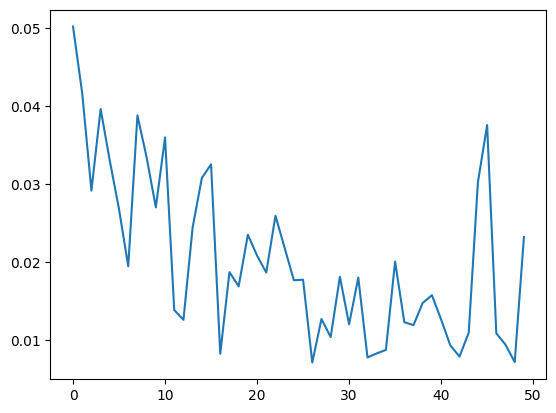

In [9]:
print(losses.index(min(losses)))
plt.plot(losses)

In [10]:
import numpy as np

differences = []

print("a")

for i, (inputs, targets, head_pose) in tqdm(enumerate(val_loader), total=int(1130/batch_size)+1):
    inputs = inputs.to(device)

    output = feature_extractor(inputs)
    output = regression_head(output["features.2"])

    if len(differences) == 0:
        differences = np.abs(targets.numpy() - output.detach().cpu().numpy())
    else:
        differences = np.vstack((differences, np.abs(targets.numpy() - output.detach().cpu().numpy())))

print(np.mean(differences, axis=0))

a


22it [00:02, 10.08it/s]                        

[0.13786866 0.10395185]
